In [1]:
from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

import h5py
import numpy as np
import glob, os, re, sys

import itertools

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import rc
rc('font',**{'family':'DejaVu Sans','sans-serif':['Helvetica']})

In [2]:
# Plotting properties
grey = '#3C3C3C'
from matplotlib import rc
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.color'] = grey
mpl.rcParams['ytick.color'] = grey
mpl.rcParams['axes.edgecolor'] = grey
mpl.rcParams['axes.labelcolor'] = grey
rc('axes', linewidth=1.5)
rc('axes', edgecolor=grey)
labels_font = {'size':'20'} 

In [3]:
def flatten_list(lst):
    if type(lst[0])==list:
        return [item for sublist in lst for item in sublist]
    else:
        return lst

In [4]:
# constants
gamma = 5./3.
kB_cgs = 1.38E-16
mp_cgs = 1.67E-24
mu = 1.4
kpc_to_cm = 3.086E21
pc_to_cm = 3.086e18
Msol_to_g = 1.99E33
Myr_to_s = 3.154E13
width_kpc = 4.
width_cm = width_kpc * kpc_to_cm
mp_g = 1.67E-24

In [32]:
# load the snapshot
# snapshot, same for all rslns
snap = h5py.File("/n/holystore01/LABS/itc_lab/Users/sjeffreson/LOW-ETGs/ICs/LOW-ics_vlM-ETG.dat-with-grid.hdf5", 'r')
header = snap['Header']
gas = snap['PartType0']
disk = snap['PartType2']
bulge = snap['PartType3']

# load the arepo particles
x = (gas['Coordinates'][:,0] - 0.5 * header.attrs['BoxSize']) * gas['Coordinates'].attrs['to_cgs']
y = (gas['Coordinates'][:,1] - 0.5 * header.attrs['BoxSize']) * gas['Coordinates'].attrs['to_cgs']
z = (gas['Coordinates'][:,2] - 0.5 * header.attrs['BoxSize']) * gas['Coordinates'].attrs['to_cgs']
U = gas['InternalEnergy'][:] * gas['InternalEnergy'].attrs['to_cgs']
rho = gas['Density'][:] * gas['Density'].attrs['to_cgs']
#SigmaStar = gas['Sigmastar'][:] * header.attrs['UnitMass_in_g'] / header.attrs['UnitLength_in_cm']**2
R = np.sqrt(x*x + y*y)
vz = gas['Velocities'][:,2] * gas['Velocities'].attrs['to_cgs']
masses = gas['Masses'][:] * gas['Masses'].attrs['to_cgs']

# load the disk
disk_x = (disk['Coordinates'][:,0] - 0.5 * header.attrs['BoxSize']) * disk['Coordinates'].attrs['to_cgs']
disk_y = (disk['Coordinates'][:,1] - 0.5 * header.attrs['BoxSize']) * disk['Coordinates'].attrs['to_cgs']
disk_z = (disk['Coordinates'][:,2] - 0.5 * header.attrs['BoxSize']) * disk['Coordinates'].attrs['to_cgs']
disk_R = np.sqrt(disk_x*disk_x + disk_y*disk_y)
disk_vz = disk['Velocities'][:,2] * disk['Velocities'].attrs['to_cgs']
disk_masses = snap['Header'].attrs['MassTable'][2] * gas['Masses'].attrs['to_cgs'] * np.ones(len(disk_x))

# load the bulge
bulge_x = (bulge['Coordinates'][:,0] - 0.5 * header.attrs['BoxSize']) * bulge['Coordinates'].attrs['to_cgs']
bulge_y = (bulge['Coordinates'][:,1] - 0.5 * header.attrs['BoxSize']) * bulge['Coordinates'].attrs['to_cgs']
bulge_z = (bulge['Coordinates'][:,2] - 0.5 * header.attrs['BoxSize']) * bulge['Coordinates'].attrs['to_cgs']
bulge_R = np.sqrt(bulge_x*bulge_x + bulge_y*bulge_y)
bulge_vz = bulge['Velocities'][:,2] * bulge['Velocities'].attrs['to_cgs']
bulge_masses = snap['Header'].attrs['MassTable'][3] * gas['Masses'].attrs['to_cgs'] * np.ones(len(bulge_x))

# add up all stars
all_x = np.concatenate((disk_x, bulge_x))
all_y = np.concatenate((disk_y, bulge_y))
all_z = np.concatenate((disk_z, bulge_z))
all_R = np.concatenate((disk_R, bulge_R))
all_vz = np.concatenate((disk_vz, bulge_vz))
all_masses = np.concatenate((disk_masses, bulge_masses))

# density map

In [37]:
# cut out gas cells at the radial limits
cnd = (R/kpc_to_cm < width_kpc/2.)
xc = x[cnd]
yc = y[cnd]
zc = z[cnd]
Rc = R[cnd]
vzc = vz[cnd]
Uc = U[cnd]
rhoc = rho[cnd]
Tc = (gamma - 1.) * Uc / kB_cgs * mu * mp_g
print(np.unique(Tc), len(Tc[Tc==0]), len(Tc[Tc>0]))
#Sigmastarc = SigmaStar[cnd]
massesc = masses[cnd]

# cut out all-star particles at radial limits
cnd = (all_R/kpc_to_cm < width_kpc/2.)
all_xc = all_x[cnd]
all_yc = all_y[cnd]
all_zc = all_z[cnd]
all_Rc = all_R[cnd]
all_vzc = all_vz[cnd]
all_massesc = all_masses[cnd]

[    0.         23773.32172191 23773.32344534 23773.32516878
 23773.32689221 23773.32861564 23773.33033907 23773.3320625
 23773.33378594 23773.33550937 23773.3372328  23773.33895623
 23773.34067967 23773.3424031  23773.34412653 23773.34584996
 23773.3475734  23773.34929683 23773.35102026 23773.35274369] 41 4065


/tmp/ipykernel_489657/317882491.py:6: RuntimeWarning: divide by zero encountered in log10
  np.log10(rhoc/mp_cgs), np.log10(Tc), massesc,
/tmp/ipykernel_489657/317882491.py:16: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(mass), origin='lower', aspect='auto',


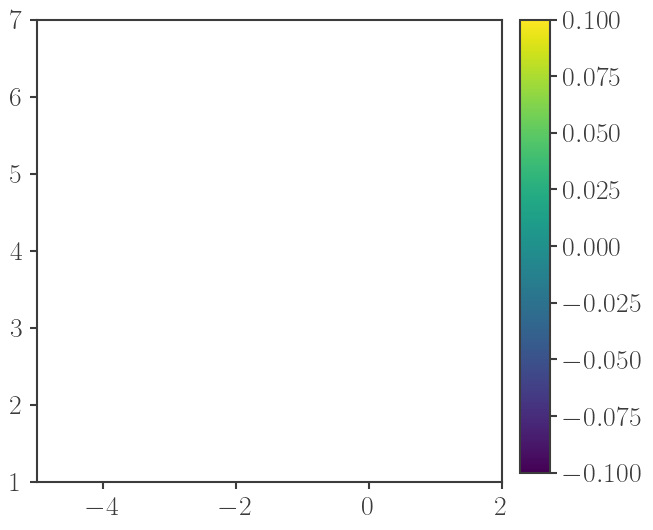

In [34]:
# phase diagram
xbin_edges = np.linspace(-5., 2., 50)
ybin_edges = np.linspace(1., 7., 50)

mass, x_edge, y_edge, binnumber_vdz = binned_statistic_2d(
    np.log10(rhoc/mp_cgs), np.log10(Tc), massesc,
    bins=(xbin_edges, ybin_edges),
    statistic='sum'
)

fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[0,0])
cax = fig.add_axes([0.93, 0.125, 0.05, 0.755])

im = ax.imshow(np.log10(mass), origin='lower', aspect='auto',
               extent=[xbin_edges[0], xbin_edges[-1], ybin_edges[0], ybin_edges[-1]], cmap='viridis')

cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r'', fontsize=20)
cbar.ax.tick_params(labelsize=20)
plt.show()

/tmp/ipykernel_3210887/2974430880.py:19: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(surfdens))


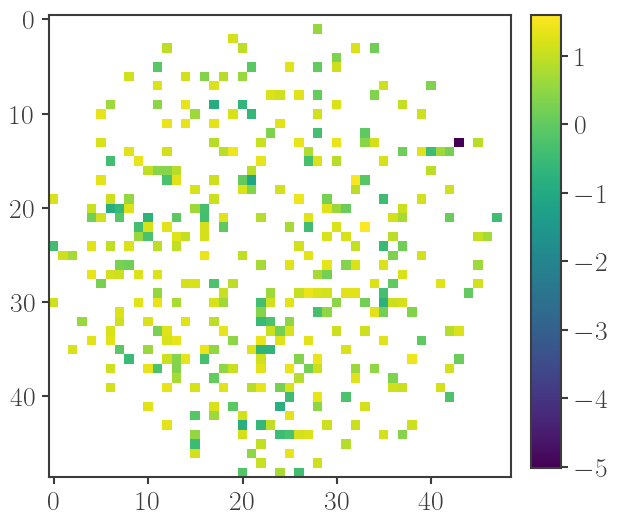

In [219]:
rsln = 80. # pc
binnum = int(np.ceil(width_kpc*1000./rsln))
xbin_edges = np.linspace(-width_kpc/2., width_kpc/2., binnum) * kpc_to_cm
ybin_edges = np.linspace(-width_kpc/2., width_kpc/2., binnum) * kpc_to_cm

surfdens, x_edge, y_edge, binnumber_vdz = binned_statistic_2d(
    xc, yc, massesc,
    bins=(xbin_edges, ybin_edges),
    statistic='sum'
)
surfdens = surfdens/Msol_to_g/rsln**2

fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[0,0])
cax = fig.add_axes([0.93, 0.125, 0.05, 0.755])

im = ax.imshow(np.log10(surfdens))

cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r'', fontsize=20)
cbar.ax.tick_params(labelsize=20)
plt.show()

/tmp/ipykernel_3210887/887576155.py:19: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(surfdens), vmin=1, vmax=4.)


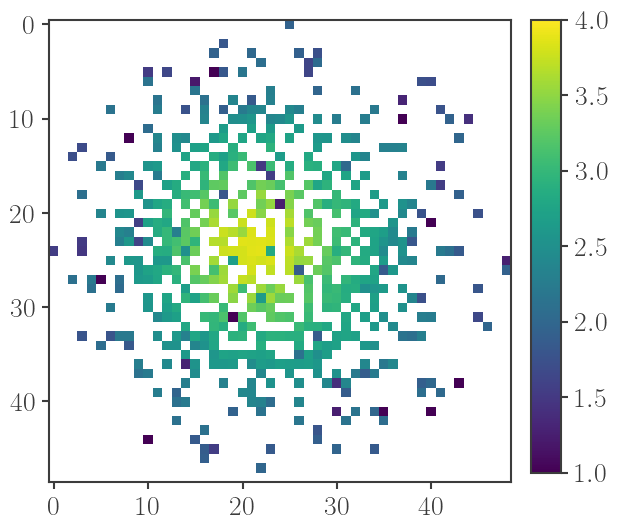

In [154]:
# # apply the cloud identification threshold as a mask
# rsln = 80. # pc
# binnum = int(np.ceil(width_kpc*1000./rsln))
# xbin_edges = np.linspace(-width_kpc/2., width_kpc/2., binnum) * kpc_to_cm
# ybin_edges = np.linspace(-width_kpc/2., width_kpc/2., binnum) * kpc_to_cm

# surfdens, x_edge, y_edge, binnumber_vdz = binned_statistic_2d(
#     xc, yc, Sigmastarc,
#     bins=(xbin_edges, ybin_edges),
#     statistic='mean'
# )
# surfdens = surfdens/Msol_to_g*pc_to_cm**2

# fig = plt.figure(figsize=(6,6))
# gs = gridspec.GridSpec(1,1)
# ax = plt.subplot(gs[0,0])
# cax = fig.add_axes([0.93, 0.125, 0.05, 0.755])

# im = ax.imshow(np.log10(surfdens), vmin=1, vmax=4.)

# cbar = fig.colorbar(im, cax=cax)
# cbar.set_label(r'', fontsize=20)
# cbar.ax.tick_params(labelsize=20)
# plt.show()

/tmp/ipykernel_3210887/1462671670.py:19: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(surfdens), vmin=1, vmax=4.)


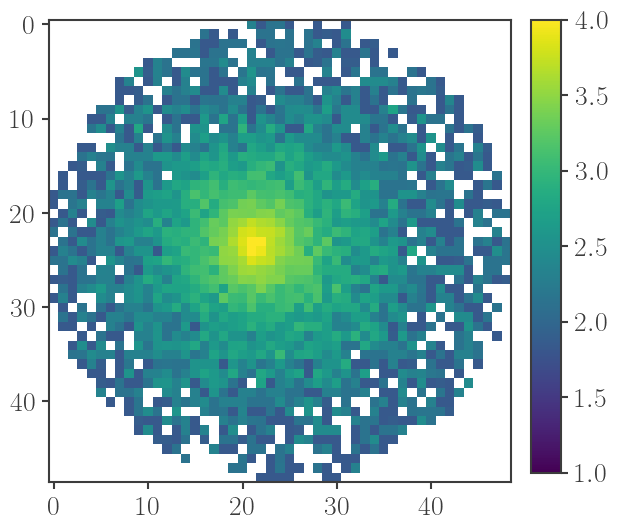

In [155]:
# apply the cloud identification threshold as a mask
rsln = 80. # pc
binnum = int(np.ceil(width_kpc*1000./rsln))
xbin_edges = np.linspace(-width_kpc/2., width_kpc/2., binnum) * kpc_to_cm
ybin_edges = np.linspace(-width_kpc/2., width_kpc/2., binnum) * kpc_to_cm

surfdens, x_edge, y_edge, binnumber_vdz = binned_statistic_2d(
    all_xc, all_yc, all_massesc,
    bins=(xbin_edges, ybin_edges),
    statistic='sum'
)
surfdens = surfdens/Msol_to_g/rsln**2

fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[0,0])
cax = fig.add_axes([0.93, 0.125, 0.05, 0.755])

im = ax.imshow(np.log10(surfdens), vmin=1, vmax=4.)

cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r'', fontsize=20)
cbar.ax.tick_params(labelsize=20)
plt.show()